<a href="https://colab.research.google.com/github/abyanjan/Pytorch-Deep-Learning/blob/master/Sentiment_classification_with_pretrained_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Sentiment Classification with Pre-trained Glove word Embeddings

Using Recurrent Neural Network - LSTM

In [ ]:
!pip install -q spacy

In [ ]:
# downloading english corpus with spacy
!python -m spacy download en

In [ ]:
import spacy
print(spacy.__version__)

2.2.4


In [ ]:
import torch
import torch.nn as nn
import torchtext
from torchtext import datasets

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data

The twitter sentiment data is downloaded from http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis Dataset.csv', error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [ ]:
data.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [ ]:
# data size
data.shape

(1578612, 4)

We will be only working with  a sample of the data for the computational purpose.

In [ ]:
# taking random 500000 samples
tweets_df = data.sample(n = 500000, replace=False)
tweets_df.shape

(500000, 4)

In [ ]:
# selecting only the required columns
tweets_df = tweets_df.drop(['ItemID', 'SentimentSource'], axis = 1)
tweets_df.head()

,Sentiment,SentimentText
1063064,0,miss my cous.... kiara
558497,0,"after Pak, now WI are in semis too...what a sh..."
1202917,1,@sammlessthan3 good night
1404830,1,frolicking among a group of recently discovere...
373266,1,"@philritchie Boom, and if you will, boom! Saw ..."


In [ ]:
# checking for any null values
tweets_df.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [ ]:
# number of sentiment classes
tweets_df.Sentiment.unique()

array([0, 1])

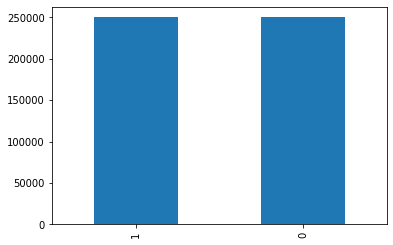

In [ ]:
# target distribution - number of positive and negative tweets
tweets_df.Sentiment.value_counts().plot(kind = 'bar')

We have almost equal examples of positive and negative sentiment tweets.  
- 0: Postitive, 1: Negative

**Splitting the data into train and test sets**

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets_df, test_size = 0.3, random_state = 2)

In [ ]:
print(train.shape)
print(test.shape)

(350000, 2)
(150000, 2)


In [ ]:
!mkdir 'datasets'

In [ ]:
# save the train and test data
train.to_csv('datasets/train_tweets.csv', index=False)
test.to_csv('datasets/test_tweets.csv', index = False)

In [ ]:
tweets_df.to_csv("datasets/tweets.csv", index=False)

### Data Processing

**Clean the text**
- Removing URLs and and keeping only letters and numbers

In [ ]:
# function to clean text
def tweet_clean(text):
  text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)
  return text.strip()

In [ ]:
# tokenizing the text with spacy
nlp = spacy.load('en', disable = ['parser', 'tagger','ner'])

def tokenizer(sent):
  return [w.text.lower() for w in nlp(tweet_clean(sent))]

In [ ]:
TEXT = torchtext.legacy.data.Field(tokenize=tokenizer, include_lengths=True, batch_first=True)
LABEL = torchtext.legacy.data.LabelField(dtype = torch.float, batch_first=True) 

**Setting torch Text Fields to process the input data**

In [ ]:
# setting the mappings for the fields
datafields = [('Sentiment', LABEL), ('SentimentText', TEXT)]

In [ ]:
# read the data
trn, tst = torchtext.legacy.data.TabularDataset.splits(path='datasets/',
                                                       train = 'train_tweets.csv',
                                                       test = 'test_tweets.csv',
                                                       format = 'csv',
                                                       skip_header =True,
                                                       fields = datafields)

In [ ]:
# create the data
dataset = torchtext.legacy.data.TabularDataset(path='datasets/tweets.csv', 
                                                format='csv', 
                                                fields = datafields,
                                                skip_header=True
                                                )

In [ ]:
# split the dataset into train and test sets
import random
trn, tst = dataset.split(split_ratio=0.7, random_state=random.seed(1))

In [ ]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of training examples: {len(tst)}')

Number of training examples: 350000
Number of training examples: 150000


In [ ]:
# a single train example
print(vars(trn.examples[2]))

{'Sentiment': '0', 'SentimentText': ['aeongotbeats', 'dang', 'parkview', 'dunno', 'if', 'i', 'got', 'my', 'twitter', 'syntax', 'straight']}


**Load pretrained Glove Embeddings**  

Building text vocabulary using glove vectors

In [ ]:
# initialize glove embeddings
TEXT.build_vocab(trn, min_freq = 5,
                 vectors = "glove.6B.300d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(trn)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 398965/400000 [00:37<00:00, 10633.78it/s]

In [ ]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

Size of TEXT vocabulary: 26172
Size of LABEL vocabulary: 2


In [ ]:
# most common words
print(TEXT.vocab.freqs.most_common(25))

[('i', 224436), ('to', 124925), ('the', 115846), ('a', 85195), ('my', 69973), ('it', 67488), ('and', 67275), ('you', 67061), ('is', 52783), ('in', 47923), ('for', 47810), ('s', 46209), ('m', 42561), ('t', 40648), ('of', 40633), ('that', 38807), ('on', 36972), ('me', 36774), ('so', 33928), ('have', 32715), ('but', 29702), ('just', 28159), ('with', 25452), ('be', 25127), ('at', 24552)]


In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'to', 'the', 'a', 'my', 'it', 'and', 'you']


In [ ]:
# push the embeddings to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

embeddings = TEXT.vocab.vectors.to(device)

cuda


**Creating Data itearators**

In [ ]:
BATCH_SIZE = 64
train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (trn, tst),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.SentimentText),
    sort_within_batch = True,
    device = device
)

### MODEL

In [ ]:
# defining the model architecture

class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
             n_layers, bidrectional, dropout, embedding_weights):
    super().__init__()

    # embedding layer
    #self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_weights)

    #rnn layer
    self.lstm = nn.LSTM(embedding_dim, hidden_size = hidden_dim, num_layers = n_layers,
                      bidirectional = bidirectional, dropout = dropout, batch_first = True)
    
    # dense layer
    self.fc = nn.Linear(hidden_dim*2, output_dim)

    # dropout
    self.dropout = nn.Dropout(dropout)

    # sigmoid activation
    self.sig = nn.Sigmoid()

  def forward(self, text, text_length):
      embedded = self.embedding(text)

      #output, hidden = self.rnn(embedded)
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.cpu(),
                                                          batch_first=True)
      packed_outputs, (hidden,cell) = self.lstm(packed_embedded)

      # concat the final forward and backward hidden state
      hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

      # dropuout
      hidden = self.dropout(hidden)

      # dense output
      dense_ouput = self.fc(hidden)

      return self.sig(dense_ouput)


**Hyperparameters**

In [ ]:
input_dim = len(TEXT.vocab)
embedding_dim = 300
embedding_weights = embeddings

hidden_dim = 20
output_dim = 1

n_layers = 2
bidirectional = True
dropout = 0.4

In [ ]:
#intiantiate the model
model = RNN(input_dim, embedding_dim,
            hidden_dim, output_dim,
            n_layers, bidirectional, dropout, embedding_weights)
model

RNN(
  (embedding): Embedding(26172, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (sig): Sigmoid()
)

**Model Training**

In [ ]:
# loss and optimizer
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr = 0.0003)
criterion = nn.BCELoss()

In [ ]:
# push the model to the device
model.to(device)

RNN(
  (embedding): Embedding(26172, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (sig): Sigmoid()
)

In [ ]:
# training loop
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0.0
  epoch_acc = 0.0 

  model.train()

  for batch in iterator:

    (text, text_length), labels = batch.SentimentText, batch.Sentiment

    #text = batch.SentimentText.to(device)
    #labels = batch.Sentiment.to(device)
    optimizer.zero_grad()

    predictions  = model(text, text_length).squeeze()
    loss = criterion(predictions, labels)

    rounded_preds = torch.round(predictions)
    correct = (rounded_preds == labels).float()

    acc = correct.sum()/len(correct)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
# evaluation on test data
def evaluate(model, iterator, criterion):

  epoch_loss = 0.0
  epoch_acc = 0.0

  model.eval()

  with torch.no_grad():

    for batch in iterator:

      #text = batch.SentimentText.to(device)
      #labels = batch.Sentiment.to(device)

      (text, text_length), labels = batch.SentimentText, batch.Sentiment

      predictions  = model(text, text_length).squeeze()
      loss = criterion(predictions, labels)

      rounded_preds = torch.round(predictions)
      correct = (rounded_preds == labels).float()

      acc = correct.sum()/len(correct)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  test_loss = epoch_loss/len(test_iterator)
  test_acc =  epoch_acc/len(test_iterator)

  return test_loss, test_acc

In [ ]:
# training the model
epochs = 10
best_test_loss = float('inf')
train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

for epoch in range(epochs):
  train_loss, train_acc = train(model, iterator=train_iterator, optimizer=optimizer, criterion=criterion)
  test_loss, test_acc = evaluate(model, iterator=test_iterator, criterion=criterion)

   #save the best model for best test loss
  if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model.state_dict(), 'saved_weights.pt')
      print("Saving best Model...")

  train_loss_epoch.append(train_loss); train_acc_epoch.append(train_acc)
  test_loss_epoch.append(test_loss); test_acc_epoch.append(test_acc)

  print(f'Epoch: {epoch+1}/{epochs}  | Train Loss: {train_loss: .3f} | Train Acc: {train_acc: .3f} | Test Loss:{test_loss:.3f} | Test Acc:{test_acc}')

Saving best Model...
Epoch: 1/10  | Train Loss:  0.512 | Train Acc:  0.747 | Test Loss:0.467 | Test Acc:0.7816344034498869
Saving best Model...
Epoch: 2/10  | Train Loss:  0.459 | Train Acc:  0.784 | Test Loss:0.445 | Test Acc:0.7910511767803199
Saving best Model...
Epoch: 3/10  | Train Loss:  0.441 | Train Acc:  0.796 | Test Loss:0.438 | Test Acc:0.7942352815699659
Saving best Model...
Epoch: 4/10  | Train Loss:  0.428 | Train Acc:  0.803 | Test Loss:0.426 | Test Acc:0.8033631968315144
Saving best Model...
Epoch: 5/10  | Train Loss:  0.419 | Train Acc:  0.808 | Test Loss:0.421 | Test Acc:0.8063762087769069
Epoch: 6/10  | Train Loss:  0.412 | Train Acc:  0.813 | Test Loss:0.423 | Test Acc:0.8054851926990336
Saving best Model...
Epoch: 7/10  | Train Loss:  0.405 | Train Acc:  0.816 | Test Loss:0.417 | Test Acc:0.8080804714163823
Saving best Model...
Epoch: 8/10  | Train Loss:  0.400 | Train Acc:  0.819 | Test Loss:0.415 | Test Acc:0.8100758141523335
Saving best Model...
Epoch: 9/10  | T

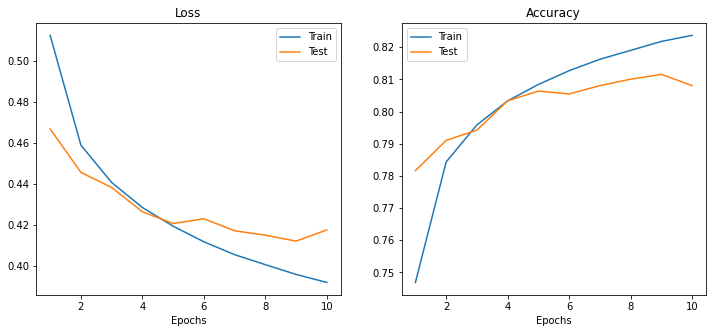

In [ ]:
# plotting the performance curve
Epochs = range(1,11)
plt.figure(figsize=(12,5))

# loss
plt.subplot(1,2,1)
plt.plot(Epochs, train_loss_epoch, label = "Train")
plt.plot(Epochs, test_loss_epoch, label = "Test")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(Epochs, train_acc_epoch, label = "Train")
plt.plot(Epochs, test_acc_epoch, label = "Test")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.show()

**Confusion Matrix**

In [ ]:
#load weights
path='/content/saved_weights.pt'
model = RNN(input_dim, embedding_dim,
            hidden_dim, output_dim,
            n_layers, bidirectional, dropout, embedding_weights)
model.load_state_dict(torch.load(path));
model.to(device)

RNN(
  (embedding): Embedding(26172, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (sig): Sigmoid()
)

In [ ]:
# get the predictions for the test data
actual = []
predicted = []

model.eval()
with torch.no_grad():

    for batch in test_iterator:

      (text, text_length), labels = batch.SentimentText, batch.Sentiment

      predictions  = model(text, text_length).squeeze()
    
      rounded_preds = torch.round(predictions).tolist()
      
      actual.extend(labels.tolist())
      predicted.extend(rounded_preds)

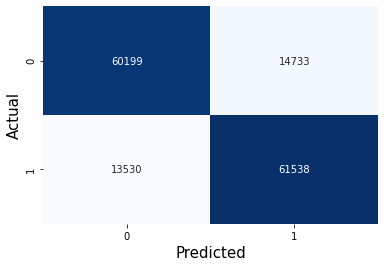

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(actual, predicted)
sns.heatmap(conf_mat, annot=True, fmt='.6g', cbar=False, cmap='Blues')
plt.xlabel('Predicted', size = 15)
plt.ylabel('Actual', size = 15)
plt.show()

**Inference on a single tweet**

In [ ]:
# making inference on cpu
path='/content/saved_weights.pt'
model = RNN(input_dim, embedding_dim,
            hidden_dim, output_dim,
            n_layers, bidirectional, dropout, embedding_weights)
model.load_state_dict(torch.load(path));

In [ ]:
model.cpu()

RNN(
  (embedding): Embedding(26172, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (sig): Sigmoid()
)

In [ ]:
#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = tokenizer(tweet_clean(sentence))               #tokenize the sentence
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    tensor = torch.LongTensor(indexed)                         #convert to tensor
    length = [len(indexed)]                                    #compute no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    prediction = model(tensor, length_tensor)                  #prediction 
    if np.round(prediction.item()) == 1:
      label = "Negative"
    else:
      label = "Positive"
    return prediction.item(), label    

In [ ]:
# positive tweet
tweet = data[data.Sentiment == 1].sample(1)
tweet = tweet.SentimentText.iloc[0]
tweet

'@mcewenrobbie Oh yes, the post-op stiches are great  ... excuse me I have to go toss up my breakfast now   heal well, think sprint!'

In [ ]:
prediction, label = predict(model,tweet)
print(f'Label: {label}\t Probability:{prediction:.4f}')

Label: Positive	 Probability:0.3820


In [ ]:
# negative tweet
tweet = data[data.Sentiment == 0].sample(1)
tweet = tweet.SentimentText.iloc[0]
tweet

'Aaahh! last.fm down due to temperature problems. What about all my scrobbles?? '

In [ ]:
prediction, label = predict(model,tweet)
print(f'Label: {label}\t Probability:{prediction:.4f}')

Label: Negative	 Probability:0.9339
